# Example 1: 1D Gaussian Mixture

In this example we'll take a 1D toy PDF (namely, a 3 component Gaussian mixture) and look at drawing samples from it in various ways.

## Python preamble

Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

Matplotlib style file

In [2]:
plt.style.use('figstyle.mplstyle')

Set up RNG (this is optional, but it makes results reproducible)

In [3]:
rng = np.random.default_rng(42)

## GMM model

We'll test a 3-component 1D Gaussian mixture model. Below we'll define a function which evaluates the PDF as a function of $x$. The means / widths / weights of the three Gaussian components are stored in the arrays `mu`, `sig` and `w` respectively. This definition has been vectorised, but the pdf does not need to be vectorised.

In [4]:
def gmm_pdf(x):
    mu = np.array([-3.0, 0.5, 2.5])
    sig = np.array([1.0, 0.25, 0.75])
    w = np.array([0.4, 0.25, 0.35])
    return np.sum([w[i] * norm.pdf(x, mu[i], sig[i]) for i in range(3)], axis=0)


Let's visualise the PDF:

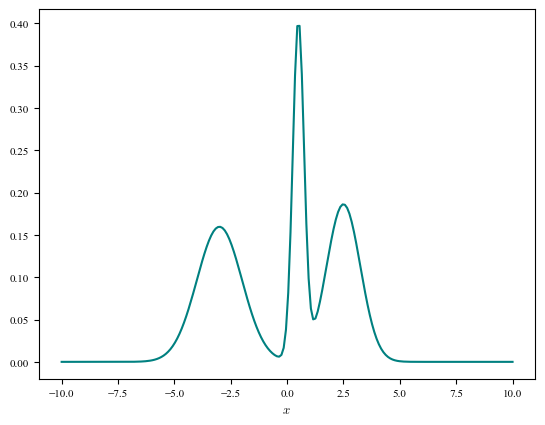

In [5]:
x = np.linspace(-10, 10, 200)
plt.plot(x, gmm_pdf(x), c='teal')
plt.xlabel('$x$', usetex=True);

## `First approach`: fixed grid

Here we'll take a fixed grid with 32 cells from $x=-12$ to $x=12$, and use `LintSampler` to draw a million samples. First import `LintSampler`:

In [6]:
from lintsampler import LintSampler

Set up the grid, and evaluate the PDF at the grid edges (note that the grid has 32 cells, so 33 edges):

In [7]:
N_cells = 32
x_min = -12
x_max = 12
fixedgrid = np.linspace(x_min,x_max,N_cells+1)

Create the `LintSampler` object, passing in the pdf and desired cell structure.

In [8]:
L = LintSampler(fixedgrid,pdf=gmm_pdf,vectorizedpdf=True,seed=rng)

Draw samples:

In [9]:
samples = L.sample(N_samples=1000000)

Now we can visualise the samples, and compare with the true PDF.

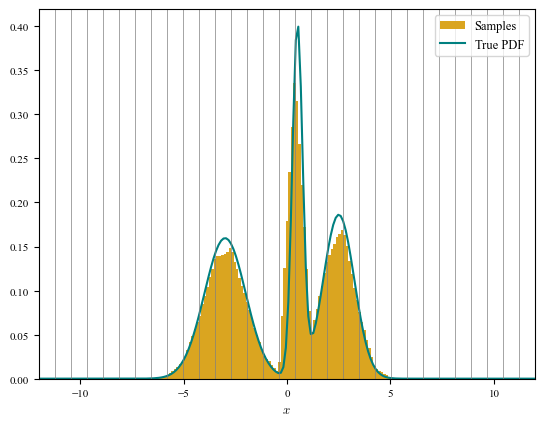

In [10]:
bins = np.linspace(-12, 12, 200)
plt.hist(samples, bins=bins, density=True, label="Samples", fc='goldenrod')
plt.plot(bins, gmm_pdf(bins), label="True PDF", c='teal')
plt.xlabel('$x$', usetex=True)
plt.legend()
plt.xlim(-12, 12)
ylim = plt.gca().get_ylim()
for edge in fixedgrid:
    plt.plot([edge, edge], ylim, c='grey', lw=0.5)
plt.ylim(ylim);

This does a pretty good job! Could be better, particularly close to the Gaussian peaks. The problem here is insufficient grid resolution. One could either increase the number of grid cells, or adopt a variable grid with more resolution where needed. We'll try the latter.

## `Second approach`: Variable grid

Now we can set up a variable grid, again with 32 cells, but now with more resolution in the relevant regions and less resolution elsewhere. Here I just hard-code the array of edges, but of course one could imagine doing something smarter.

In [11]:
variablegrid = np.hstack([
    np.linspace(-12, -5, 4, endpoint=False),
    np.linspace(-5, -0, 8, endpoint=False),
    np.linspace(0, 5, 16, endpoint=False),
    np.linspace(5, 12, 5, endpoint=True),
])

L = LintSampler(variablegrid,pdf=gmm_pdf,vectorizedpdf=True,seed=rng)

Draw samples:

In [12]:
samples = L.sample(N_samples=1000000)

Visualise:

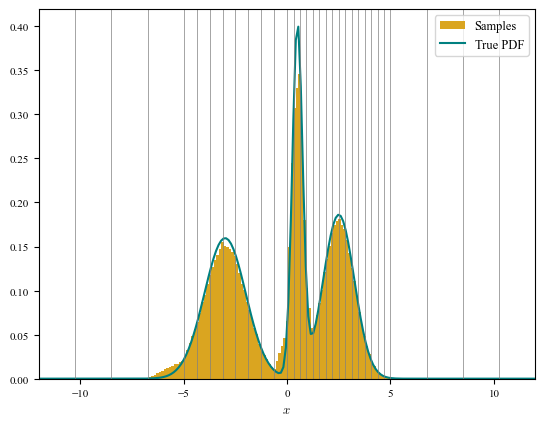

In [13]:
bins = np.linspace(-12, 12, 200)
plt.hist(samples, bins=bins, density=True, label="Samples", fc='goldenrod')
plt.plot(bins, gmm_pdf(bins), label="True PDF", c='teal')
plt.xlabel('$x$', usetex=True)
plt.legend()
plt.xlim(-12, 12)
ylim = plt.gca().get_ylim()
for edge in variablegrid:
    plt.plot([edge, edge], ylim, c='grey', lw=0.5)
plt.ylim(ylim);

That's better!

## `Third Approach`: Separate grids

We are not required to have one continuous grid as the input to `LintSampler`. In fact, in this case, with three distinct peaks, we might want to consider grids that only sample around the peaks. We'll pass a list of three grids, centred at the peaks.

In [14]:
peakgrids = [
    np.linspace(-5., -1., 12),
    np.linspace(0., 1., 12),
    np.linspace(1.25, 3.75, 12),
]

L = LintSampler(peakgrids,pdf=gmm_pdf,vectorizedpdf=True,seed=rng)

Draw samples:

In [15]:
samples = L.sample(N_samples=1000000)

Visualise:

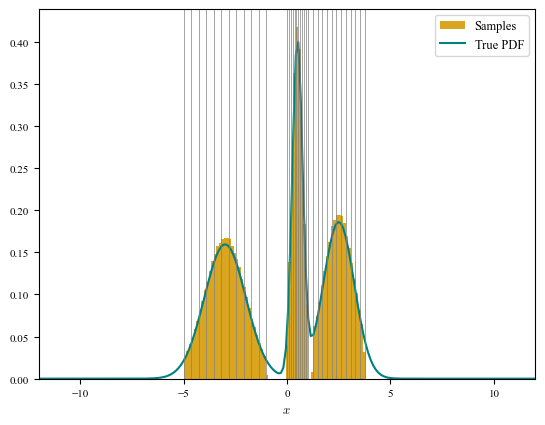

In [16]:
bins = np.linspace(-12, 12, 200)
plt.hist(samples, bins=bins, density=True, label="Samples", fc='goldenrod')
plt.plot(bins, gmm_pdf(bins), label="True PDF", c='teal')
plt.xlabel('$x$', usetex=True)
plt.legend()
plt.xlim(-12, 12)
ylim = plt.gca().get_ylim()
for edge in np.hstack(peakgrids):
    plt.plot([edge, edge], ylim, c='grey', lw=0.5)
plt.ylim(ylim);

It isn't a better result than before, but it does demonstrate another way we could increase sampling near peaks in the pdf.

## Final checks

Let's just check that we do get near-perfect results if we increase the number of grid cells a lot. Here is outcome of a fixed grid with 512 cells:

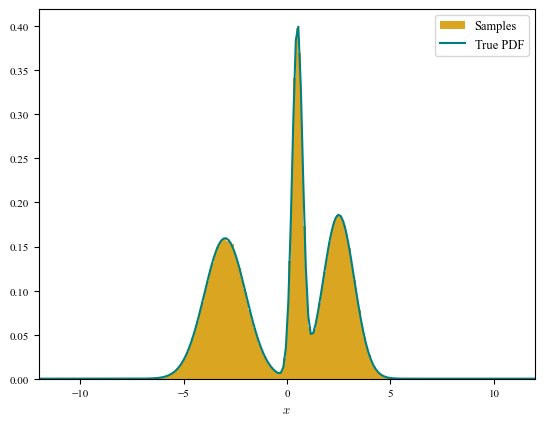

In [17]:
N_cells = 512
x_min = -12
x_max = 12
fixedgridhires = np.linspace(x_min,x_max,N_cells)

L = LintSampler(fixedgridhires,pdf=gmm_pdf,vectorizedpdf=True,seed=rng)
samples = L.sample(N_samples=1000000)
bins = np.linspace(-12, 12, 200)
plt.hist(samples, bins=bins, density=True, label="Samples", fc='goldenrod')
plt.plot(bins, gmm_pdf(bins), label="True PDF", c='teal')
plt.xlabel('$x$', usetex=True)
plt.legend()
plt.xlim(-12, 12);

Just for fun, we can take the samples and fit a Gaussian mixture model just to check that we get results that roughly match the 'truths'.

In [18]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=3).fit(samples[:, None])
order = np.argsort(gm.means_.squeeze())
print(f"Fitted means:\n {gm.means_[order].squeeze()}")
print(f"True means:\n {[-3.0, 0.5, 2.5]}\n")

print(f"Fitted widths:\n {np.sqrt(gm.covariances_[order]).squeeze()}")
print(f"True widths:\n {[1.0, 0.25, 0.75]}\n")

print(f"Fitted weights:\n {gm.weights_[order]}")
print(f"True weights:\n {[0.4, 0.25, 0.35]}\n")

Fitted means:
 [-3.00350256  0.50507934  2.51636658]
True means:
 [-3.0, 0.5, 2.5]

Fitted widths:
 [0.99849371 0.25711878 0.73456591]
True widths:
 [1.0, 0.25, 0.75]

Fitted weights:
 [0.40017738 0.25386334 0.34595928]
True weights:
 [0.4, 0.25, 0.35]



So, the fitted GMM parameters very closely match the truths.